<a href="https://colab.research.google.com/github/ravimashru/rps-classifier/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock Paper Scissor classifier

First, let us download the [rock_paper_scissors TensorFlow Dataset](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors).

In [1]:
!curl https://storage.googleapis.com/download.tensorflow.org/data/rps.zip --output rps.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  191M  100  191M    0     0   100M      0  0:00:01  0:00:01 --:--:--  100M


Once we extract the dataset, we will have our data in the following structure:

```
rps
├── rock
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ...
├── paper
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ...
└── scissors
    ├── image1.jpg
    ├── image2.jpg
    └── ...
```

In [ ]:
!unzip rps.zip

Let's install the `fastbook` library and import it.

In [ ]:
!pip install fastbook

In [3]:
from fastbook import *

Now, we create a `DataBlock` to specify:

1. The kind of data we're dealing with (images and categorical labels)
2. A function to fetch images from the dataset we downloaded
3. How to split the dataset into training and validation sets
4. Use the name of the folder an image is in as the label for the image
5. Resize each image to a size of 128x128 pixels

In [4]:
rps = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

Next, we create a `DataLoaders` instance passing the location of our dataset.

In [5]:
path = Path()
dls = rps.dataloaders(path)

Let us see a few images from the validation set to ensure everything works fine.

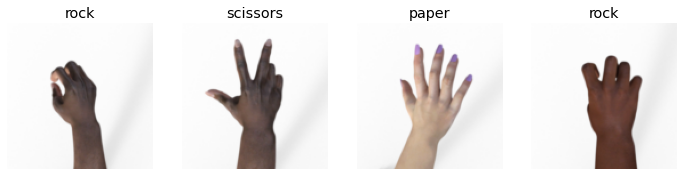

In [6]:
dls.valid.show_batch(max_n=4, nrows=1)

Now, we load a pretrained `resnet18` model and fine tune it on the dataset.

Calling `fine_tune(4)` will train the model for one epoch with the weights frozen so that the new head gets calibrated, and then 4 epochs with weights unfrozen.

In [7]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,0.442286,0.006846,0.001984,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.007235,0.000576,0.000000,00:09
1,0.004802,0.000041,0.000000,00:09
2,0.003805,0.000164,0.000000,00:09
3,0.002125,0.000078,0.000000,00:09


An `error_rate` of 0 means the model is making correct predictions for all images in the validation set! Let's confirm that by taking a look at the confusion matrix.

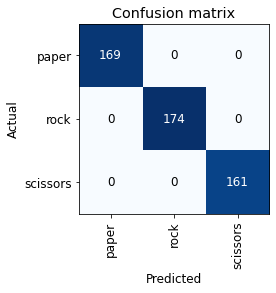

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Perfect!

We can now save the weights of our model so that we can load them in the notebook we'll use to create a web application.

In [9]:
learn.export()